# Introduction

In this notebook, we build models and write inference algorithms using Pyro. Pyro is a deep probabilistic programming language built on top of PyTorch.

# Model building

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

import warnings
warnings.filterwarnings("ignore")

pyro.set_rng_seed(101)

We can use pyro to build statistical model which is a Python function that contains probablistic 
statements.

In [ ]:
dist.Bernoulli

In [2]:
# weather model
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10., 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

In [4]:
pyro.sample?

Signature: pyro.sample(name, fn, *args, **kwargs)
Docstring:
Calls the stochastic function `fn` with additional side-effects depending
on `name` and the enclosing context (e.g. an inference algorithm).
See `Intro I <http://pyro.ai/examples/intro_part_i.html>`_ and
`Intro II <http://pyro.ai/examples/intro_part_ii.html>`_ for a discussion.

:param name: name of sample
:param fn: distribution class or function
:param obs: observed datum (optional; should only be used in context of
    inference) optionally specified in kwargs
:param dict infer: Optional dictionary of inference parameters specified
    in kwargs. See inference documentation for details.
:returns: sample
File:      ~/miniconda3/envs/sdk/lib/python3.6/site-packages/pyro/primitives.py
Type:      function


We can run this model repeatedly to simulate the world. This is also called a generative model since we can generate data.

In [3]:
for _ in range(3):
    print(weather())

('cloudy', 51.373016357421875)
('cloudy', 52.28388595581055)
('sunny', 70.28937530517578)


This ``weather()`` model specifies a joint distribution over two random variable ``cloudy`` and ``temp``. Using this model, we can answer different questions using different inference techniques. 

# Inferences

Inference over probablistic models means anwswer probablistic queries given some observations. For example, what is the likelihood of weather being rainy if the temperature is 60.0.

Let's build a simple model.

In [4]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

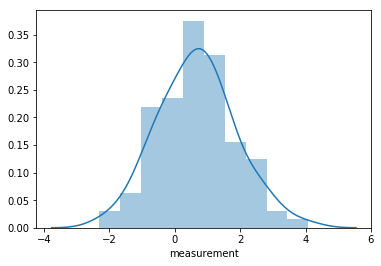

In [5]:
measurement = [scale(0.45) for _ in range(100)]
sns.distplot(measurement)
plt.xlabel('measurement');

A typical inference task is to compute a posterior distribution. Let's compute p(weight|guess, measurement=9.5)? Ok using some calculus, we derive a closed form for  p(weight|guess, measurement=9.5).

In [6]:
def perferect_conditioned_prob(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

In [7]:
guess = torch.tensor(8.5)


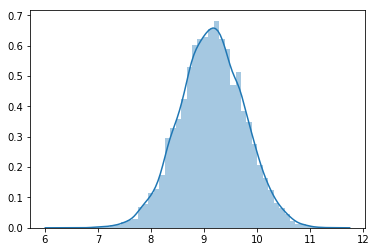

In [8]:
sns.distplot([perferect_conditioned_prob(guess) for _ in range(10000)])

But say we do not know how to do this because the math is hard and we also lazy too. We can use Pyro black box variational inference to compute an approximiate to the true posterior of weight, p(weight|guess, measurement=9.5)?.

First, we can create a conditional model

In [9]:
conditioned_scale = pyro.condition(scale, data={'measurement': 9.5})

In [10]:
from torch.distributions import constraints

In [5]:
pyro.param?

Signature: pyro.param(name, *args, **kwargs)
Docstring:
Saves the variable as a parameter in the param store.
To interact with the param store or write to disk,
see `Parameters <parameters.html>`_.

:param str name: name of parameter
:param init_tensor: initial tensor or lazy callable that returns a tensor.
    For large tensors, it may be cheaper to write e.g.
    ``lambda: torch.randn(100000)``, which will only be evaluated on the
    initial statement.
:type init_tensor: torch.Tensor or callable
:param constraint: torch constraint, defaults to ``constraints.real``.
:type constraint: torch.distributions.constraints.Constraint
:param int event_dim: (optional) number of rightmost dimensions unrelated
    to baching. Dimension to the left of this will be considered batch
    dimensions; if the param statement is inside a subsampled plate, then
    corresponding batch dimensions of the parameter will be correspondingly
    subsampled. If unspecified, all dimensions will be considered eve

In [11]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

a =  0.5887603163719177
b =  9.149964332580566


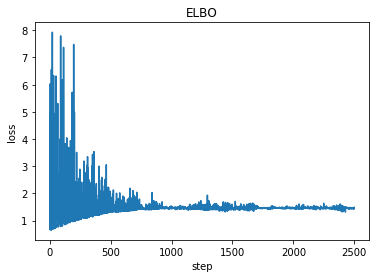

In [12]:

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("b").item())
print('b = ', pyro.param("a").item())

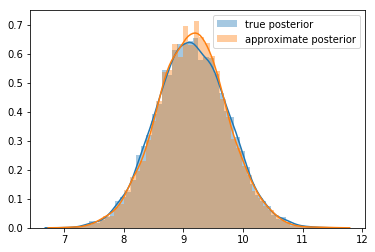

In [13]:
N = 10000
sns.distplot([perferect_conditioned_prob(guess) for _ in range(N)], label='true posterior')
sns.distplot(dist.Normal(pyro.param("a"), pyro.param("b")).sample((N,)), label='approximate posterior')
plt.legend();